In [307]:
# import library
import pandas as pd
import mysql.connector
import os
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import plotly.express as px
import sqlite3

# download important library
!pip install pymysql
!pip install pymysql pandas


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('order_items.csv', 'order_items'),
    ('payments.csv', 'payments'),
    ('geolocation.csv', 'geolocation')
]

# make connection between MYSQL and python

In [380]:
import pymysql

conn = pymysql.connect(
    host='localhost',
    user='root',
    password='Nishant@2001',
    database='e_Commerce'
)

cur = conn.cursor()

# upload files in database 

In [20]:
folder_path = '/Users/nishantmehra/Desktop/data'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

# show All Tables in e_Commerce database

In [425]:
query = ("""
SHOW tables
""")
cur.execute(query)
data = cur.fetchall()
data = pd.DataFrame(data, columns = ["Tables"])
data

,Tables
0,customers
1,geolocation
2,order_items
3,orders
4,payments
5,products
6,sellers


#                                  Data Modelling / Relationship Between Tables
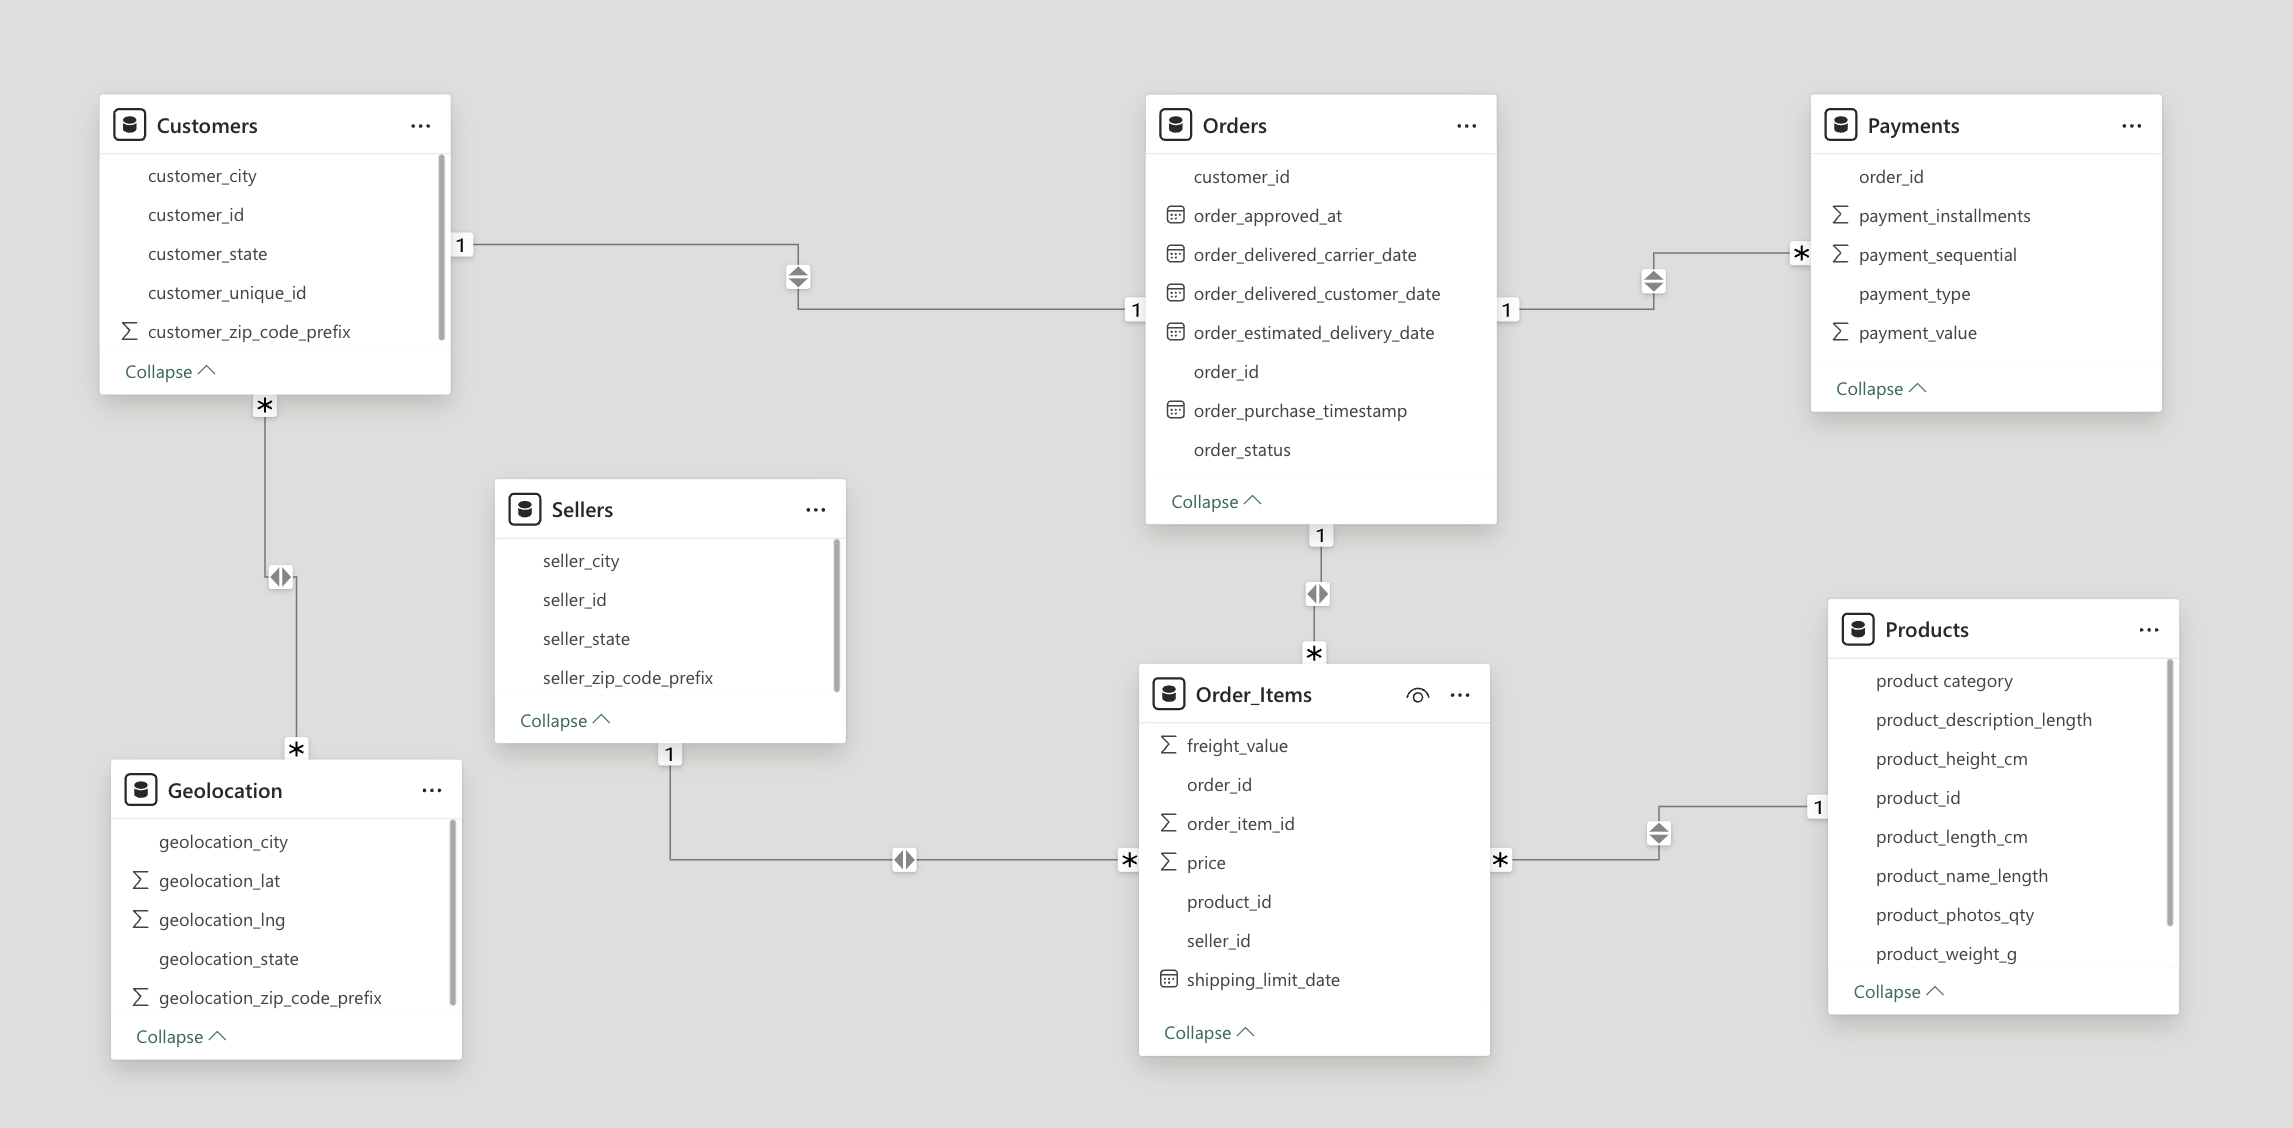


# Calculate the moving average of order values for each customer over their order history.

In [426]:
query = ("""
select customer_id, 
order_purchase_timestamp, 
AVG(payment) OVER(partition by customer_id order by order_purchase_timestamp ROWS between 2 preceding and current row) as moving_avg
from (
    select orders.customer_id, orders.order_purchase_timestamp, payments.payment_value as payment
    from orders JOIN payments 
    ON orders.order_id = payments.order_id
) as t
""")
cur.execute(query)
data = cur.fetchall()
data = pd.DataFrame(data, columns = ["customer_id","order_purchase_timestamp","moving_avg"])
data

,customer_id,order_purchase_timestamp,moving_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.010002
...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.500000


# Calculate the cumulative sales per month for each year.

In [427]:
query = ("""
select CONCAT(CAST(year AS CHAR), '-', LPAD(CAST(month AS CHAR), 2, '0')) AS month_years,
SUM(price) over(order by year, month) as cum_payment
from (
SELECT 
    year(orders.order_purchase_timestamp) AS year, 
    month(orders.order_purchase_timestamp) AS month,
    SUM(payments.payment_value) AS price
FROM orders JOIN payments
ON orders.order_id = payments.order_id
group by year, month    
order by year, month asc
) as t
""")
cur.execute(query)
data = cur.fetchall()
data = pd.DataFrame(data, columns = ["month_years","cum_payment"])
data

,month_years,cum_payment
0,2016-09,2.522400e+02
1,2016-10,5.934272e+04
2,2016-12,5.936234e+04
3,2017-01,1.978504e+05
4,2017-02,4.897584e+05
5,2017-03,9.396220e+05
6,2017-04,1.357410e+06
7,2017-05,1.950329e+06
8,2017-06,2.461605e+06
9,2017-07,3.053988e+06


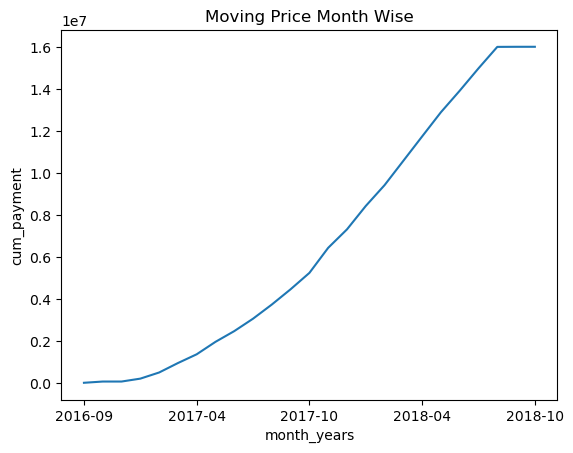

In [431]:
sns.lineplot(data, x = "month_years", y = "cum_payment")
plt.title("Moving Price Month Wise")
plt.xticks(["2016-09","2017-04","2017-10","2018-04","2018-10"]) 
plt.show()

# Calculate the year-over-year growth rate of total sales.

In [432]:
query = ("""
with year_price AS (
        select 
            YEAR(orders.order_purchase_timestamp) as year,
            SUM(order_items.price + order_items.freight_value) as price
        FROM orders 
        JOIN order_items 
ON orders.order_id = order_items.order_id
GROUP BY year(orders.order_purchase_timestamp)
)
select year, 
sum(price) OVER(partition by year ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) as cum_price
from year_price
ORDER BY year

""")
cur.execute(query)
data = cur.fetchall()
data = pd.DataFrame(data, columns = ["year","cum_price"])
data

,year,cum_price
0,2016,5.718321e+04
1,2017,7.142672e+06
2,2018,8.643698e+06


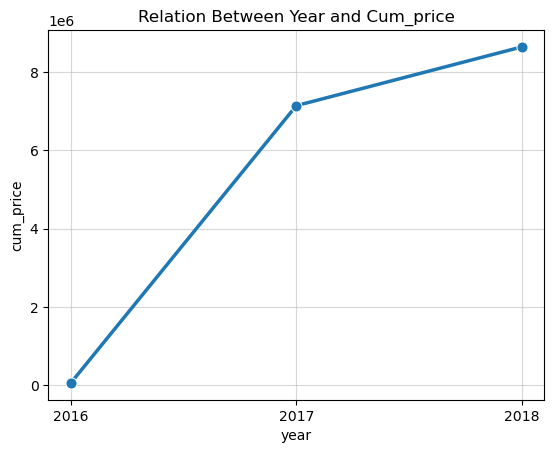

In [433]:
sns.lineplot(data, x = "year", y = "cum_price", marker='o', linewidth=2.5, markersize=8)
plt.title("Relation Between Year and Cum_price")
plt.xticks([2016, 2017, 2018]) 
plt.grid(True, alpha=0.5)
plt.show()

# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [424]:
query = ("""
with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id
""")
cur.execute(query)
data = cur.fetchall()
data = pd.DataFrame(data)
data

,0
0,None


# Identify the top 3 customers who spent the most money in each year.

In [436]:
query = ("""select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 """)
cur.execute(query)
data = cur.fetchall()
data = pd.DataFrame(data, columns = ["year","customer_id","payment","Rank"])
data

,year,customer_id,payment,Rank
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,1423.550049,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,1400.739990,2
2,2016,4a06381959b6670756de02e07b83815f,1227.780029,3
3,2017,1617b1357756262bfa56ab541c47bc16,13664.080078,1
4,2017,c6e2731c5b391845f6800c97401a43a9,6929.310059,2
5,2017,3fd6777bbce08a352fddd04e4a7cc8f6,6726.660156,3
6,2018,ec5b2ba62e574342386871631fafd3fc,7274.879883,1
7,2018,f48d464a0baaea338cb25f816991ab1f,6922.209961,2
8,2018,e0a2412720e9ea4f26c1ac985f6a7358,4809.439941,3


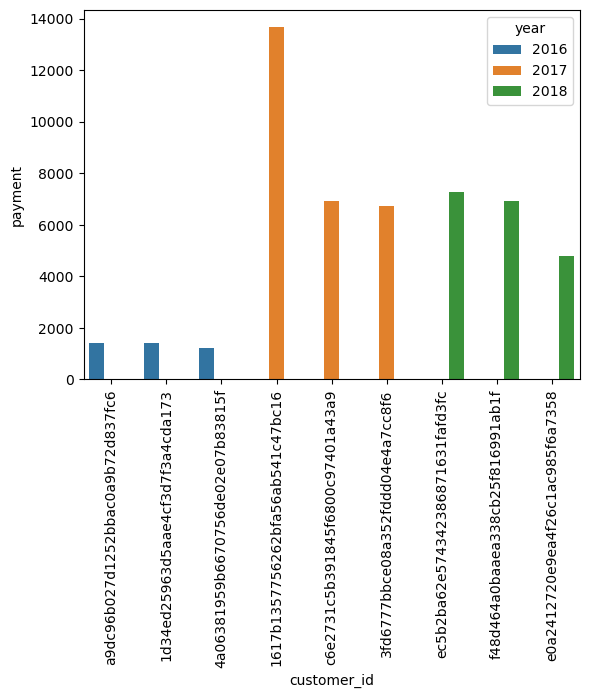

In [437]:
sns.barplot(x = "customer_id", y = "payment", data = data, hue = "year")
plt.xticks(rotation = 90)
plt.show()

# Identify the correlation between product price and the number of times a product has been purchased.

In [413]:
query = ("""
WITH product_purchases AS (
    SELECT 
    product_id,
    AVG(price) AS avg_price,
    COUNT(order_id) AS num_purchases
    FROM order_items
    GROUP BY product_id
)
SELECT 
ROUND(avg_price,2) as avg_price,
num_purchases
FROM product_purchases
order by num_purchases desc
""")
cur.execute(query)
data = cur.fetchall()
data = pd.DataFrame(data, columns = ["avg_price","num_purchases"])
data

,avg_price,num_purchases
0,71.36,527
1,88.17,488
2,54.91,484
3,54.70,392
4,54.27,388
...,...,...
32946,355.00,1
32947,15.90,1
32948,42.50,1
32949,163.09,1


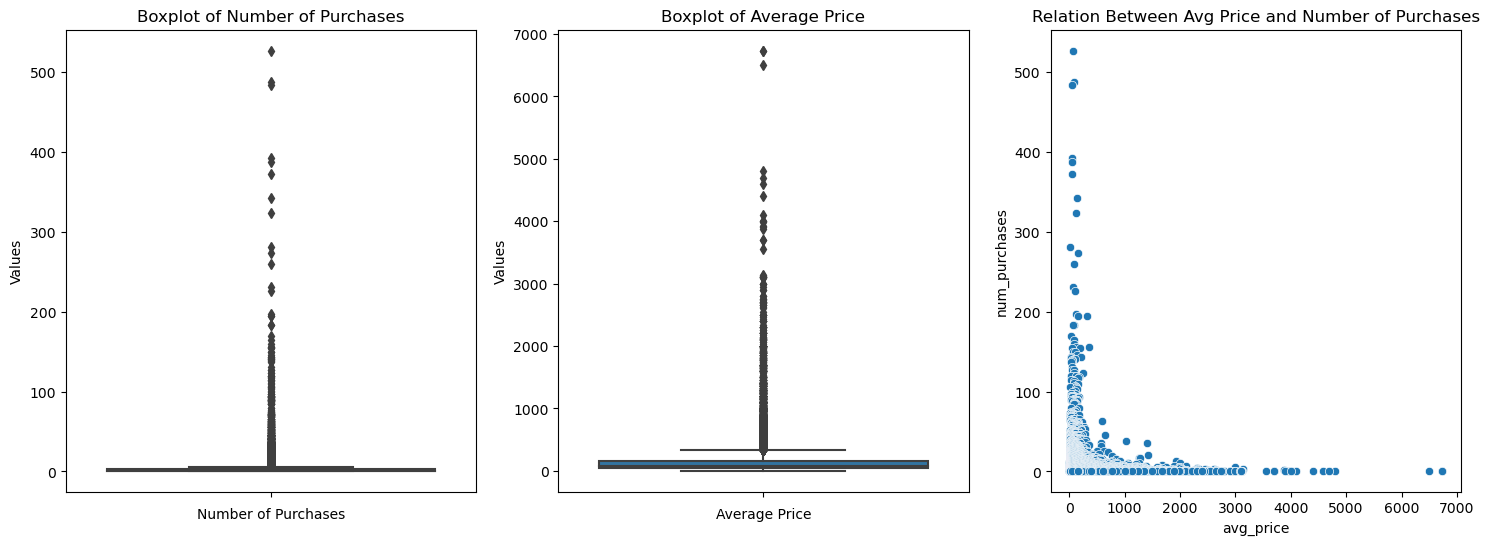

In [414]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# first box plot for num_purchases
sns.boxplot(data=t7, y="num_purchases", ax=ax[0])
ax[0].set_title("Boxplot of Number of Purchases")
ax[0].set_xlabel("Number of Purchases")
ax[0].set_ylabel("Values")

# second box plot for avg_price
sns.boxplot(data=t7, y="avg_price", ax=ax[1])
ax[1].set_title("Boxplot of Average Price")
ax[1].set_xlabel("Average Price")
ax[1].set_ylabel("Values")

# scatter plot for avg_price vs num_purchases
sns.scatterplot(data=t7, x="avg_price", y="num_purchases", ax=ax[2])
ax[2].set_title("Relation Between Avg Price and Number of Purchases")

plt.show()

# Calculate the total revenue generated by each seller, and rank them by revenue

In [386]:
query = ("""
select *, dense_rank() over(order by revenue desc) as ranks 
from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as t
""")

cur.execute(query)
data = cur.fetchall()
data = pd.DataFrame(data,columns = ["seller_id", "revenue","Rank"])
data


,seller_id,revenue,Rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.907302,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.039840,2
2,4a3ca9315b744ce9f8e9374361493884,301245.269765,3
3,1f50f920176fa81dab994f9023523100,290253.420128,4
4,53243585a1d6dc2643021fd1853d8905,284903.080498,5
...,...,...,...
3090,ad14615bdd492b01b0d97922e87cb87f,19.209999,3082
3091,702835e4b785b67a084280efca355756,18.559999,3083
3092,4965a7002cca77301c82d3f91b82e1a9,16.360001,3084
3093,77128dec4bec4878c37ab7d6169d6f26,15.220000,3085


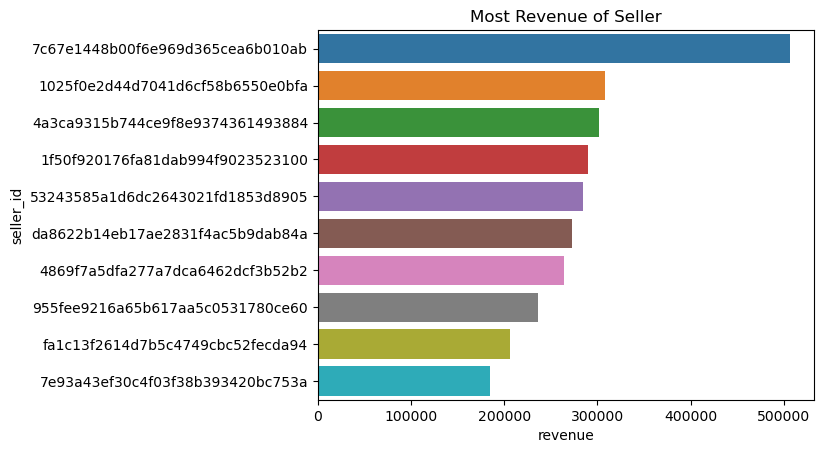

In [390]:
sns.barplot(data = data.head(10) , x = "revenue", y = "seller_id")
plt.title("Most Revenue of Seller")
plt.show()

# Calculate the percentage of total revenue contributed by each product category.

In [392]:
query = ("""
WITH total_sum AS (
    SELECT SUM(price) AS p FROM order_items
)

SELECT 
    products.product_category, 
    ROUND((SUM(order_items.price) / (SELECT p FROM total_sum)) * 100,2) AS "percentage_of_total(%)"
FROM products
JOIN order_items ON products.product_id = order_items.product_id
GROUP BY products.product_category
ORDER BY SUM(order_items.price) DESC;
""")
cur.execute(query)
data = cur.fetchall()
data = pd.DataFrame(data, columns = ["category","price (%)"])
data

,category,price (%)
0,HEALTH BEAUTY,9.26
1,Watches present,8.87
2,bed table bath,7.63
3,sport leisure,7.27
4,computer accessories,6.71
...,...,...
69,flowers,0.01
70,House Comfort 2,0.01
71,cds music dvds,0.01
72,Fashion Children's Clothing,0.00


# Find the average number of products per order, grouped by customer city.

In [399]:
query = ("""
with count_per_order AS ( 
    SELECT 
        COUNT(order_items.order_id) as oc, 
        orders.customer_id
    FROM orders JOIN order_items
    ON orders.order_id = order_items.order_id
group by orders.customer_id, orders.order_id 
)

select customers.customer_city, ROUND(AVG(count_per_order.oc),2) as avg_count
FROM count_per_order 
JOIN customers 
ON count_per_order.customer_id = customers.customer_id
GROUP BY customers.customer_city
order by ROUND(AVG(count_per_order.oc),2) desc
""")
cur.execute(query)
data = cur.fetchall()
data = pd.DataFrame(data, columns = ["customer_city","avg_count"])
data

,customer_city,avg_count
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
...,...,...
4105,lagoa da canoa,1.00
4106,japaratuba,1.00
4107,sebastiao leal,1.00
4108,morro agudo de goias,1.00


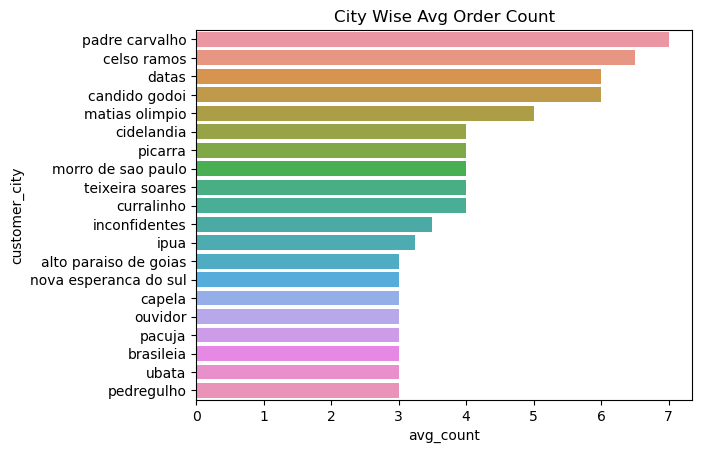

In [400]:
sns.barplot(data = data.head(20), x = "avg_count", y = "customer_city")
plt.title("City Wise Avg Order Count")
plt.show()

# Calculate the number of orders per month in 2018.

In [396]:
query = ("""
SELECT t.count, t.month FROM (
SELECT COUNT(order_id) as count, MONTHNAME(order_purchase_timestamp) as month, YEAR(order_purchase_timestamp) as year
FROM orders
GROUP BY MONTHNAME(order_purchase_timestamp),YEAR(order_purchase_timestamp)
) as t
WHERE t.year = 2018
order by t.count desc
""")
cur.execute(query)
data = cur.fetchall()
data = pd.DataFrame(data, columns = ["count","month"])
data

,count,month
0,7269,January
1,7211,March
2,6939,April
3,6873,May
4,6728,February
5,6512,August
6,6292,July
7,6167,June
8,16,September
9,4,October


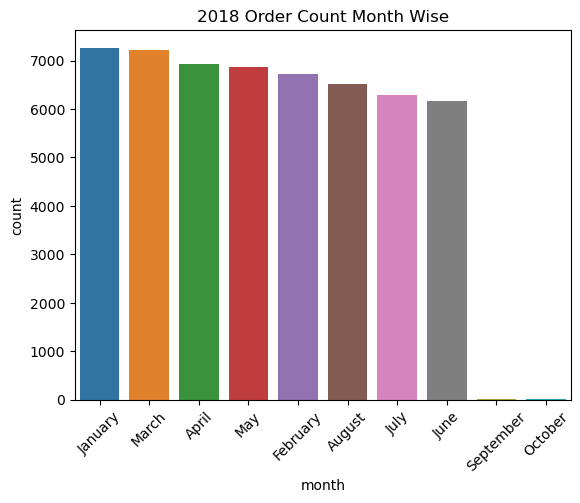

In [397]:
sns.barplot(data = data, x = "month", y = "count")
plt.title("2018 Order Count Month Wise")
plt.xticks(rotation = 45)
plt.show()

# Calculate the percentage of orders that were paid in installments.

In [403]:
query = (""" 
select (sum(case when payment_installments > 1 then 1 else 0 end) / COUNT(*))*100 as Average_Count
from payments;
""")
cur.execute(query)
data = cur.fetchall()
data = pd.DataFrame(data, columns = ["Avg Count"])
data

,Avg Count
0,49.4176


# Count the number of customers from each state.

In [404]:
query = ("""
SELECT customer_state, COUNT(customer_unique_id) as customer_count
FROM customers
GROUP BY customer_state
order by COUNT(customer_unique_id) desc
""")
cur.execute(query)
data = cur.fetchall()
data = pd.DataFrame(data, columns = ["customer_state","customer_count"])
data

,customer_state,customer_count
0,SP,41746
1,RJ,12852
2,MG,11635
3,RS,5466
4,PR,5045
5,SC,3637
6,BA,3380
7,DF,2140
8,ES,2033
9,GO,2020


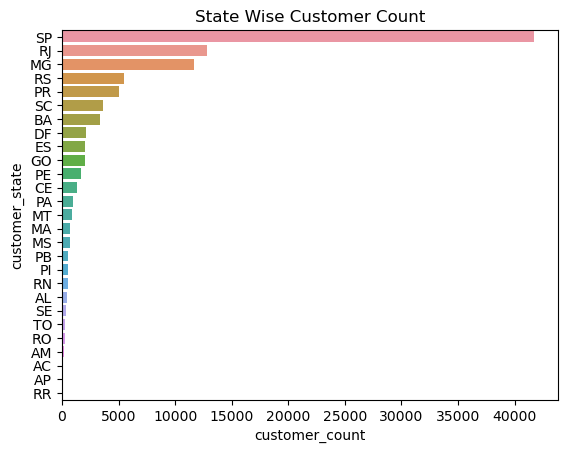

In [405]:
sns.barplot(data = data, x = "customer_count" ,y = "customer_state")
plt.title("State Wise Customer Count")
plt.show()

# Find the total sales per category.

In [438]:
query = ("""
select products.product_category as category, 
SUM(payments.payment_value) as sales
from products 
JOIN order_items
ON products.product_id = order_items.product_id
JOIN payments
ON payments.order_id = order_items.order_id
GROUP BY category
order by SUM(payments.payment_value) desc
""")
cur.execute(query)
data = cur.fetchall()
data = pd.DataFrame(data, columns = ["category","sales"])
data

,category,sales
0,bed table bath,1.712554e+06
1,HEALTH BEAUTY,1.657373e+06
2,computer accessories,1.585330e+06
3,Furniture Decoration,1.430176e+06
4,Watches present,1.429217e+06
...,...,...
69,PC Gamer,2.174430e+03
70,House Comfort 2,1.710540e+03
71,cds music dvds,1.199430e+03
72,Fashion Children's Clothing,7.856700e+02


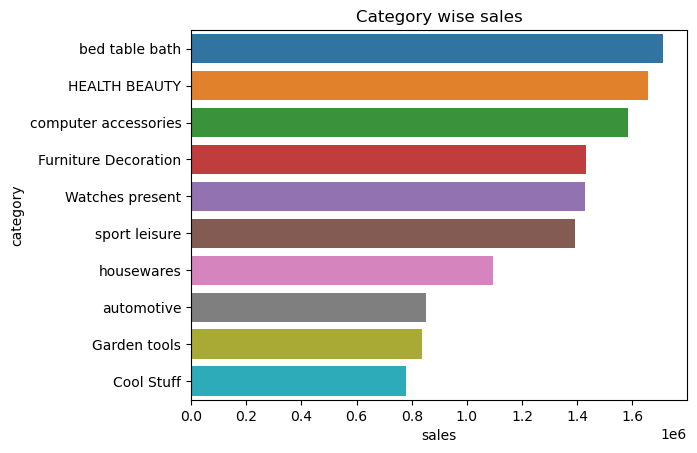

In [439]:
sns.barplot(data = data.head(10), x = "sales", y = "category")
plt.title("Category wise sales")
plt.show()

# Count the number of orders placed in 2017.

In [411]:
query = ("""
SELECT COUNT(*) as order_count, YEAR(order_approved_at) as year
FROM orders
WHERE YEAR(order_approved_at) = 2017
GROUP BY YEAR(order_approved_at)
""")
cur.execute(query)
data = cur.fetchall()
data = pd.DataFrame(data, columns = ["order_count","year"])
data

,order_count,year
0,44973,2017


# List all unique cities where customers are located.

In [412]:
query = ("""
SELECT DISTINCT(customer_city) 
from customers
""")
cur.execute(query)
data = cur.fetchall()
data = pd.DataFrame(data, columns = ["customer_city"])
data

,customer_city
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael
